In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import json
import re
from glob import glob
import msgpack
import pickle
from sktime.performance_metrics.forecasting import mean_squared_scaled_error

In [2]:
loss_paths = sorted(glob("result/online_1_slide/experiment_*/analysis/loss.csv"))
server_config_paths = sorted(glob("result/online_1_slide/experiment_*/server_config.json"))
# system_metrics_paths = sorted(glob("result/online_1_slide/experiment_*/analysis/system_df.csv"))
predictions_paths = sorted(glob("result/online_1_slide/experiment_*/analysis/predictions.csv"))

In [3]:
result = []
for conf_path, loss_path, predictions_path in zip(
    server_config_paths, loss_paths, predictions_paths
):
    conf = json.load(open(conf_path))
    loss_df = pd.read_csv(loss_path)
    # system_df = pd.read_csv(system_metrics_path)
    prediction_df = pd.read_csv(predictions_path)

    if conf["use_per_key_slide_size_plan"]:
        slide_side = re.match(".*plan_(.*).json", conf["per_key_slide_size_plan_path"]).group(1)
    else:
        slide_side = conf["global_slide_size"]

    
    # max_cpu = int(system_df.groupby("time")["cpu"].sum().mean())
    total_loss = loss_df["loss"].dropna().sum()
    log_loss = np.log10(loss_df["loss"].dropna().sum())
    num_missing_keys = loss_df["loss"].isna().sum()
    total_predictions = len(prediction_df)

    result.append(
        {
            "slide_size": slide_side,
            "total_loss": total_loss,
            "mapper_replicas": conf["map_num_replicas"],
            # "cpu": max_cpu,
            "num_mapper": conf["map_num_replicas"],
            "num_missing_keys": num_missing_keys,
            "total_predictions": total_predictions,
            "log10_loss": log_loss,
        }
    )
result_df = pd.DataFrame(result)


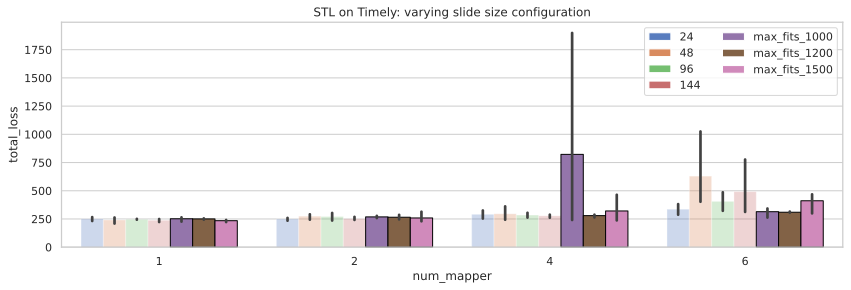

In [11]:
plt.figure(figsize=(12,4))
ax = sns.barplot(data=result_df, hue="slide_size", y="total_loss", x="num_mapper")
plt.tight_layout()
plt.title("STL on Timely: varying slide size configuration")
plt.legend(ncol=2)
for i in range(16):
    ax.patches[i].set_alpha(0.3)
for i in range(16, 28):
    # ax.patches[i].set_hatch("/")
    ax.patches[i].set_edgecolor("black")

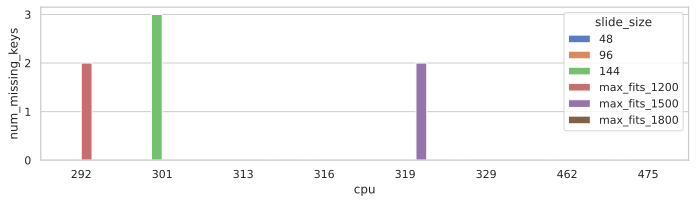

In [16]:
plt.figure(figsize=(10,3))
sns.barplot(data=result_df, hue="slide_size", y="num_missing_keys", x="cpu")
plt.tight_layout()

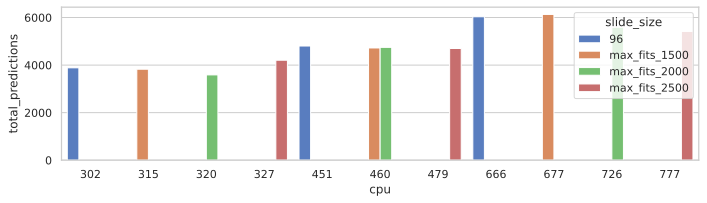

In [7]:
plt.figure(figsize=(10,3))
sns.barplot(data=result_df, hue="slide_size", y="total_predictions", x="cpu")
plt.tight_layout()

In [8]:
plan_file = "./offline/result/offline_1_slide/min_loss_plan_max_fits_1500.json"
vary_slide_plan = json.load(open(plan_file))

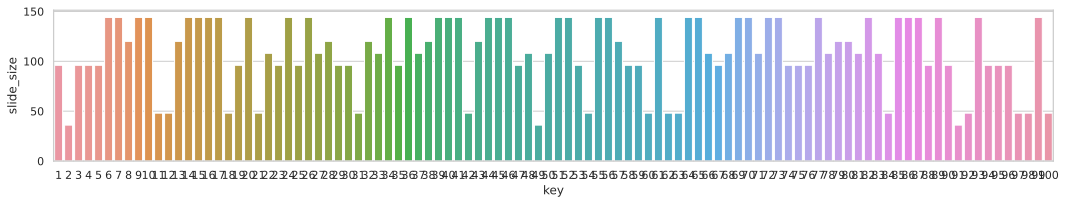

In [9]:
plt.figure(figsize=(15,3))
vary_slide_df = pd.Series(vary_slide_plan).to_frame().reset_index().rename(columns={"index": "key", 0: "slide_size"})
sns.barplot(data=vary_slide_df, x="key", y="slide_size")
plt.tight_layout()